In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [5]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_auc_score

In [6]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [8]:
word2vec={}
with open(os.path.join('./glove.6B.%sd.txt'% EMBEDDING_DIM), encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

In [9]:
len(word2vec)

400000

In [10]:
train = pd.read_csv("train.csv")
sentences = train["comment_text"].fillna("DUMMY VALUE").values

In [13]:
possible_labels = ["toxic",'severe_toxic','obscene','threat','insult','identity_hate']
targets = train[possible_labels].values

In [15]:
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences=tokenizer.texts_to_sequences(sentences)

In [17]:
len(sequences)

159571

In [18]:
word2idx = tokenizer.word_index

In [21]:
len(word2idx)

210337

In [22]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [23]:
data.shape

(159571, 100)

In [24]:
# Prepare embedding Matrix

In [25]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

In [26]:
num_words

20000

In [27]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [30]:
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros
            embedding_matrix[i] = embedding_vector

In [33]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [34]:
# Building Model

In [36]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

In [38]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

In [39]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Epoch 1/5
998/998 [==============================] - 159s 102ms/step - loss: 0.2013 - accuracy: 0.7563 - val_loss: 0.0695 - val_accuracy: 0.9940
Epoch 2/5
998/998 [==============================] - 92s 92ms/step - loss: 0.0663 - accuracy: 0.9941 - val_loss: 0.0626 - val_accuracy: 0.9939
Epoch 3/5
998/998 [==============================] - 92s 92ms/step - loss: 0.0615 - accuracy: 0.9935 - val_loss: 0.0601 - val_accuracy: 0.9917
Epoch 4/5
998/998 [==============================] - 90s 90ms/step - loss: 0.0573 - accuracy: 0.9924 - val_loss: 0.0581 - val_accuracy: 0.9929
Epoch 5/5
998/998 [==============================] - 96s 97ms/step - loss: 0.0562 - accuracy: 0.9917 - val_loss: 0.0562 - val_accuracy: 0.9923


In [40]:
#PLOTTING

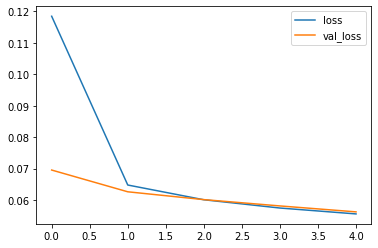

In [41]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

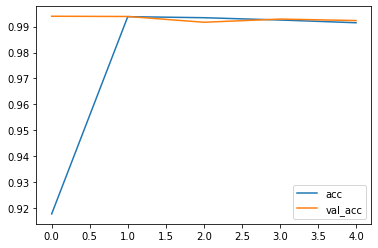

In [42]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [43]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)

In [44]:
np.mean(aucs)

0.9707544157943158